In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
from datetime import datetime, timezone, timedelta

from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

In [4]:
data_filepath = './rawdata/Mar07_stepwise1.dat'

log_filepath = './log/PMX_2021-03-07.dat'

item_filepath = './Ether/item/items_2021-03-07.dat'
item = 'measurement'

storedir = './Ether/plots/'
storename_init = '20210307_stepwise1'

<span style="font-size: 200%; color: red;">Caution: Make sure you set correct paths.</span>

# input data and log

In [6]:
item_df = pd.read_csv(item_filepath, delim_whitespace=True)
item_df

,#Date,Time-Timezone,Item,Start/Stop
0,2021-03-07,00:35:01-UTC,calibration,start
1,2021-03-07,02:11:34-UTC,calibration,stop
2,2021-03-07,10:17:19-UTC,measurement,start
3,2021-03-07,11:50:03-UTC,measurement,start
4,2021-03-07,12:22:06-UTC,measurement,start
5,2021-03-07,12:24:09-UTC,measurement,start
6,2021-03-07,12:40:50-UTC,measurement,start
7,2021-03-07,13:38:15-UTC,measurement,stop
8,2021-03-07,14:22:54-UTC,calibration,start
9,2021-03-07,15:59:27-UTC,calibration,stop


In [ ]:
PRU_Clock_Counts = 200e6
Deg = 360/52000

start_line = np.where(item_df.iloc[:,2] == item)[0][-2]
start_at = item_df.iloc[:,0].to_numpy()[start_line] + ' ' + item_df.iloc[:,1].to_numpy()[start_line]
stop_at = item_df.iloc[:,0].to_numpy()[start_line + 1] + ' ' + item_df.iloc[:,1].to_numpy()[start_line + 1]

In [ ]:
df0 = pd.read_csv(log_filepath, delim_whitespace=True)
start_slice = np.where(start_at == df0.iloc[:,0].to_numpy()+' '+df0.iloc[:,1].to_numpy())[0][0]
stop_slice = np.where(stop_at == df0.iloc[:,0].to_numpy()+' '+df0.iloc[:,1].to_numpy())[0][0]

df = df0[start_slice:stop_slice]

In [13]:
time_category0, error0, direction0, timercount0, reference0 = np.loadtxt(data_filepath, comments='#', unpack=True)

## check the rawdata

Text(0, 0.5, 'difference counts of lines')

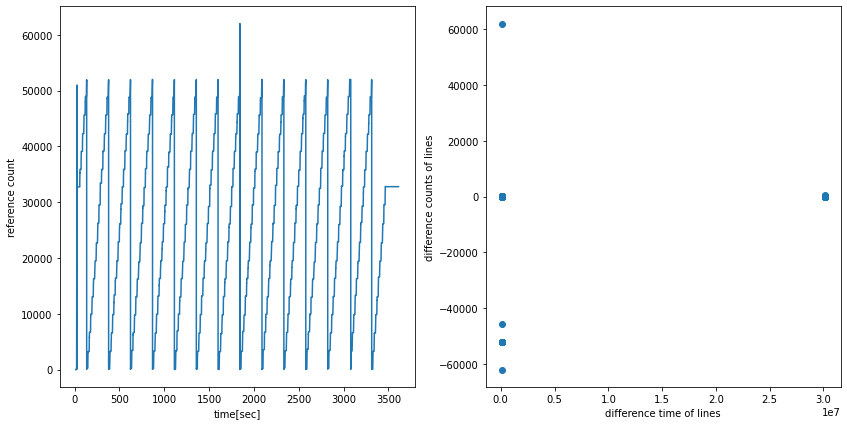

In [14]:
#first scketch of the rawdata
fig01, axarr01 = plt.subplots(1,2,figsize=(14,7))
ax01 = axarr01.ravel()

ax01[0].plot((timercount0/PRU_Clock_Counts)[::100], reference0[::100])
ax01[0].set_xlabel('time[sec]')
ax01[0].set_ylabel('reference count')

ax01[1].scatter(np.diff(timercount0), np.diff(reference0))
ax01[1].set_xlabel('difference time of lines')
ax01[1].set_ylabel('difference counts of lines')

In [15]:
error_point = np.where((np.diff(timercount0) > 110000) | (np.diff(timercount0) < 90000))[0]
len(error_point)

15

In [16]:
for i in range(len(error_point)):
    print(f'{np.diff(timercount0)[error_point[i]]/200e6}')

0.15050294
0.15050289
0.150502805
0.15050278
0.15050265
0.15050284
0.15050286
0.1505412
0.15055507
0.15050671
0.150543945
0.1505028
0.150503015
0.150502755
0.150503065


# Set variables

In [9]:
# if operation item is 'measurement'
num_laps = 14

In [18]:
# set matrix
iteration = 16*num_laps
list_amp = [3.0]
list_intv = ['0.401']
matrix_size = 1

pack_size = 1

In [19]:
plot_slice = 30
capture_slice = 500

capture_offset = 4

casp_threshold = -100

isUTC = False # True: UTC, False: JST

In [20]:
def packet_capture(dataframe, list_ampere, list_interval, UnixTime_Data):
    UTC = timezone(timedelta(hours=+0), 'UTC')
    JST = timezone(timedelta(hours=+9), 'JST')
    initial_UnixTime = []
    switching_UnixTime = []
    start_UnixTime = []

    for i in range(iteration):
        start_UnixTime.append([])

    for i in list_ampere:
        for j in list_interval:
            list_datetime = ((dataframe[dataframe.iloc[:,5] == i])[(dataframe[dataframe.iloc[:,5] == i]).iloc[:,8] == j]).iloc[:,0:2].to_numpy()
            for k in range(len(list_datetime)):
                if k%pack_size == 0:
                    if isUTC == True:
                        start_UnixTime[int(k/pack_size)] = (((datetime.strptime(list_datetime[k][0]+' '+list_datetime[k][1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(UTC)).timestamp()
                        pass
                    else:
                        start_UnixTime[int(k/pack_size)] = (((datetime.strptime(list_datetime[k][0]+' '+list_datetime[k][1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()
                        pass
                    initial_UnixTime = np.append(initial_UnixTime, start_UnixTime[int(k/pack_size)])
                    pass
                pass
            switching_UnixTime.append(min(start_UnixTime))
            pass
        pass

    stop_UnixTime = dataframe[dataframe.iloc[:,2] == 'OFF'].iloc[-1,:]
    if isUTC == True:
        end_UnixTime = (((datetime.strptime(stop_UnixTime[0]+' '+stop_UnixTime[1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(UTC)).timestamp()
        pass
    else:
        end_UnixTime = (((datetime.strptime(stop_UnixTime[0]+' '+stop_UnixTime[1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()
        pass

    captured_initials = []
    captured_switching = []
    
    for i in range(len(switching_UnixTime)):
        captured_switching.append(max(np.where(UnixTime_Data[::capture_slice] <= switching_UnixTime[i])[0]))
        pass
    
    for i in range(len(initial_UnixTime)):
        captured_initials.append(max(np.where(UnixTime_Data[::capture_slice] <= initial_UnixTime[i])[0]))
        pass
    
    captured_end = min(np.where(end_UnixTime + capture_offset <= UnixTime_Data[::capture_slice])[0])
    
    return captured_switching, captured_initials, captured_end

In [37]:
swt, inits, end = packet_capture(df, list_amp, list_intv, time_category0)

In [38]:
min(error0)

1.0

<span style="font-size: 200%; color: red;">Caution: Make sure there are no errors.</span>
* min(error0) = 1.0: no error catched

In [39]:
reference = reference0
ref_tmp = np.where(reference0 > 52000)[0]

for i in ref_tmp:
    reference[i] = reference0[i]-62000

In [40]:
# check and release the memory
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000: # set the size of object
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       df|   2130452|
|                      df0|   9812006|
|                    inits|      1928|
|                  item_df|      3606|


In [41]:
del df0, df

In [42]:
# divide by block
time = timercount0/PRU_Clock_Counts
time_block = []
reference_block = []

for i in range(len(swt)-1):
    slice0 = int(np.where(time == (time[::capture_slice])[swt[i]-capture_offset])[0])
    slice1 = int(np.where(time == (time[::capture_slice])[swt[i+1]-capture_offset])[0])
    time_block.append(time[slice0:slice1])
    reference_block.append(reference[slice0:slice1])
    pass
time_block.append(time[int(np.where(time == (time[::capture_slice])[swt[-1]-capture_offset])[0])
                                                 :int(np.where(time == (time[::capture_slice])[end+capture_offset])[0])])
reference_block.append(reference[int(np.where(time == (time[::capture_slice])[swt[-1]-capture_offset])[0])
                                 :int(np.where(time == (time[::capture_slice])[end+capture_offset])[0])])

lincount_block = []
block_initials = []
onecycle_time = []
proceeded_degrees = []

for i in range(matrix_size):
    lincount_block.append([])
    lincount_block[i] = np.array(np.zeros(len(reference_block[i])))
    
    count_offset = 0
    casp_flag = 0
    casp = np.where(np.diff(reference_block[i]) <= casp_threshold)[0].tolist()

    for j in range(len(reference_block[i])):
        lincount_block[i][j] = reference_block[i][j]+count_offset
        if casp:
            if j == casp[casp_flag]:
                count_offset += reference_block[i][casp[casp_flag]]
                if len(casp) > casp_flag+1:
                    casp_flag += 1
                    pass
                pass
            pass
        pass
    
    block_initials.append([])
    for j in range(iteration):
        block_initials[i].append(int(np.where(time_block[i] == (time[::capture_slice])[(inits[i*iteration:(i+1)*iteration])[j]-capture_offset])[0]))
        pass
    
    onecycle_time.append([])
    proceeded_degrees.append([])
    for j in range(iteration):
        if j != iteration - 1:
            onecycle_time[i].append(time_block[i][block_initials[i][j+1]]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][block_initials[i][j+1]]-lincount_block[i][block_initials[i][j]])*Deg)
            pass
        else:
            onecycle_time[i].append(time_block[i][-1]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][-1]-lincount_block[i][block_initials[i][j]])*Deg)
        pass
    pass

# Plots

## (for stepwise) check the shapes

In [43]:
cut_threshold = 8

<span style="font-size: 200%; color: red;">Caution: make sure all events stoped the left-hand side to the vertical line</span>

(-1.0, 4.0)

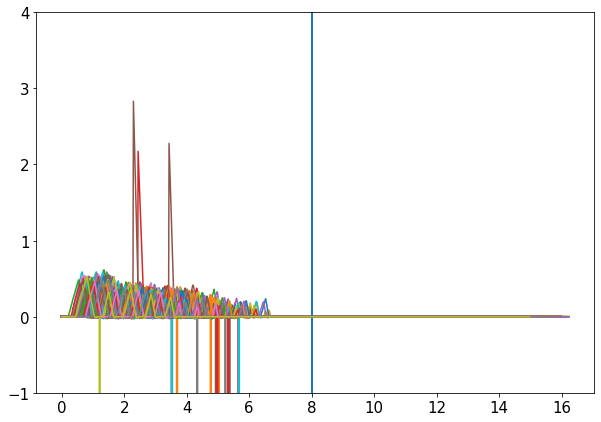

In [58]:
# each shape
fig10 = plt.figure(figsize=(10,7))

for i in range(matrix_size):
    for j in range(len(inits)-5):
        tmp_timeblock = time_block[i][block_initials[i][j]:block_initials[i][j+1]]-time_block[i][block_initials[i][j]]
        place = min(np.where(tmp_timeblock >= cut_threshold)[0])
        plt.axvline(tmp_timeblock[place])
        plt.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]],
                    np.diff((reference_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])*Deg,label=f'num_{j}')
        pass
    pass
plt.ylim([-1,4])

Text(0, 0.5, 'proceeded degree')

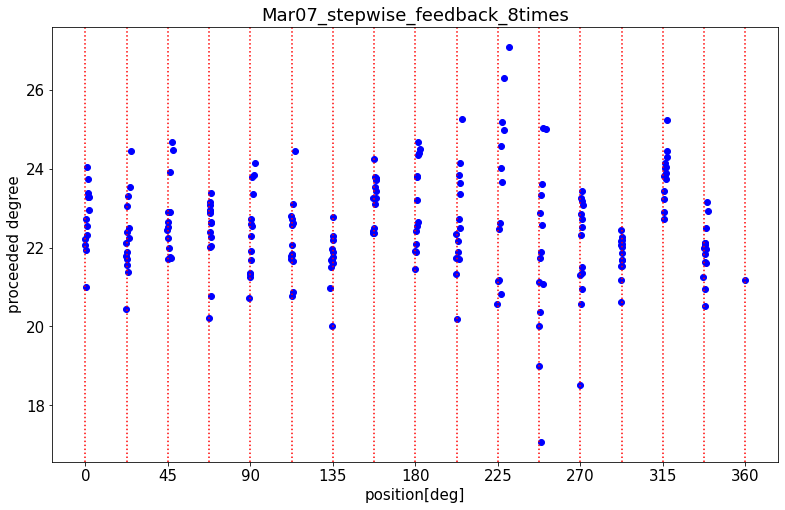

In [67]:
# position v.s. proceeded angle
moved_angle = []
end_position = []

fig20, ax20 = plt.subplots(figsize=(13,8))
plt.rcParams["font.size"] = 15

for i in range(matrix_size):
    moved_angle.append([])
    end_position.append([])
    for j in range(iteration-1):
        tmp_timeblock = time_block[i][block_initials[i][j]:block_initials[i][j+1]]-time_block[i][block_initials[i][j]]
        place = min(np.where(tmp_timeblock >= cut_threshold)[0])
        moved_angle[i].append((lincount_block[i][block_initials[i][j] + place]-lincount_block[i][block_initials[i][j]])*Deg)
        end_position[i].append(lincount_block[i][block_initials[i][j] + place]%52000*Deg)
        pass
    ax20.scatter(end_position[i], moved_angle[i], color='b')
    pass

for i in range(len(np.arange(0,382.5,22.5))):
    ax20.axvline(np.arange(0,382.5,22.5)[i], ls=':', color='r')
    pass

#plt.ylim([10,30])

ax20.xaxis.set_major_locator(tik.MultipleLocator(45))

ax20.set_title(f'Mar07_stepwise_feedback_8times')
ax20.set_xlabel('position[deg]')
ax20.set_ylabel('proceeded degree')

In [53]:
end_position[0][0]

248.26846153846154

<span style="font-size: 200%; color: red;">Sorry, please match the value of A and B by hand.</span>
* set x2[0] ~ end_position[0][0] by changing roll_size

In [10]:
roll_size = 5

In [11]:
x1 = np.arange(0,360,22.5)
x2 = np.roll(x1, roll_size)
x3 = np.tile(x2, num_laps)
x2[0]

247.5

In [79]:
goal = end_position[0]

hoge = np.where(np.array(end_position[0]) > 350)[0]

for i in hoge:
    x3[i] = 360

In [50]:
def linear_func(x,a,b):
    return a*x+b

In [54]:
popt, pcov = curve_fit(linear_func, x3[:-1], goal)
popt

array([1.00058073, 0.63828618])

No handles with labels found to put in legend.


(-6.0, 6.0)

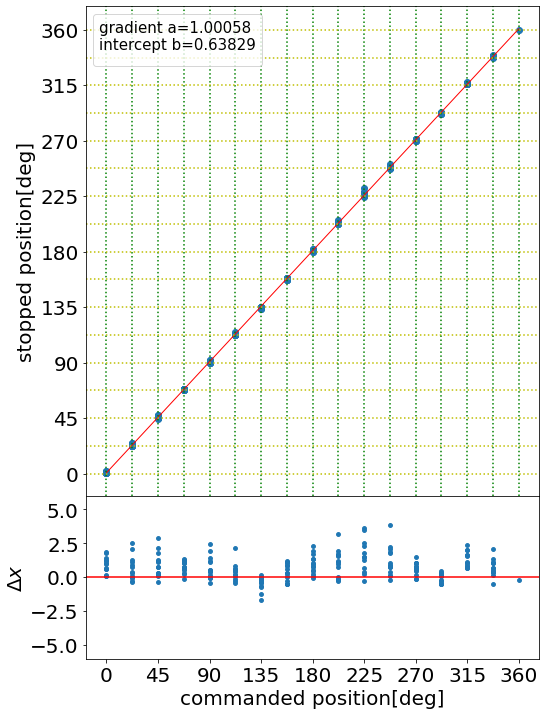

In [82]:
# commanded v.s. stopped
fig30, axarr30 = plt.subplots(2,1,figsize=(9,12), gridspec_kw={'height_ratios':[3,1]})
plt.rcParams["font.size"] = 15
fsize0 = 20
ax30 = axarr30.ravel()
plt.subplots_adjust(hspace=0.,left=0.2)

piyo = np.linspace(0,360,len(x3[:-1]))

ax30[0].scatter(x3[:-1], goal)
ax30[0].plot(piyo, linear_func(piyo, popt[0], popt[1]),color='r', lw=1)

hoge = np.arange(0,382.5,22.5)
for i in range(len(hoge)):
    ax30[0].axvline(hoge[i], ls=':', color='g')
    ax30[0].axhline(hoge[i], ls=':', color='y')

ax30[0].set_ylabel('stopped position[deg]',fontsize=fsize0)
ax30[0].yaxis.set_major_locator(tik.MultipleLocator(45))
ax30[0].legend(loc='upper left', title=f'gradient a={round(popt[0],5)}\nintercept b={round(popt[1],5)}')

ax30[1].scatter(x3[:-1], goal-x3[:-1], s=15)
ax30[1].axhline(0, color='r')
ax30[1].set_xlabel('commanded position[deg]',fontsize=fsize0)
ax30[1].set_ylabel('$\Delta x$',fontsize=fsize0)
ax30[1].xaxis.set_major_locator(tik.MultipleLocator(45))
ax30[1].set_ylim([-6,6])

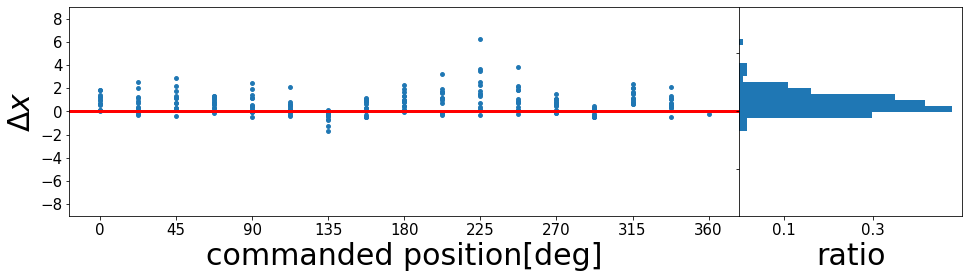

In [81]:
# difference
fig40, axarr = plt.subplots(1,2,figsize=(16,5),gridspec_kw={'width_ratios':[3,1]})
ax = axarr.ravel()
plt.rcParams["font.size"] = 20
plt.subplots_adjust(wspace=0.,bottom=0.3)

ax[1].tick_params(labelleft=False)

ax[0].scatter(x3[:-1], goal-x3[:-1], s=15)
ax[0].axhline(0,color='r',lw=3)
ax[0].set_ylabel('$\Delta x$',fontsize=30)
ax[0].set_xlabel('commanded position[deg]',fontsize=30)

ax[0].xaxis.set_major_locator(tik.MultipleLocator(45))
ax[0].yaxis.set_major_locator(tik.MultipleLocator(2))
ax[0].set_ylim([-9,9])

ax[1].hist(goal-x3[:-1],bins=15, orientation="horizontal",density=True)
ax[1].set_xlabel('ratio',fontsize=30)
ax[1].set_ylim([-9,9])
ax[1].xaxis.set_major_locator(tik.FixedLocator([0.1,0.3,0.5,0.7]))